K-Means

In [111]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
%run parse.py
from mpl_toolkits.mplot3d import Axes3D

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [112]:
sql = '''
SELECT *  FROM `eth-tokens.test.clean_avg_1MM_with_balances_tokens`
'''

df = client.query(sql).to_dataframe()

In [113]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [114]:
#number of PCA features is full reconstruction, for now
# num_features = data.shape[1]
num_clusters = 4
num_features = 15

In [115]:
log = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
power_transform = PowerTransformer(standardize=False)
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('log', power_transform ),
                 ('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)




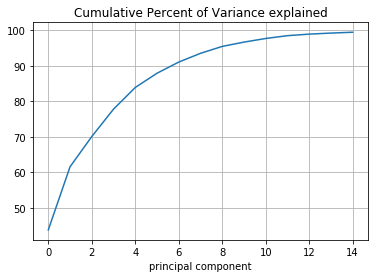

In [116]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

Text(0.5,1,'Calinski Harabaz Scores')

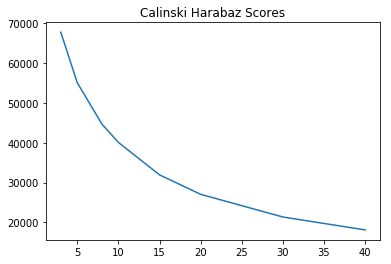

In [54]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [3,5,8,10,15,20,30,40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

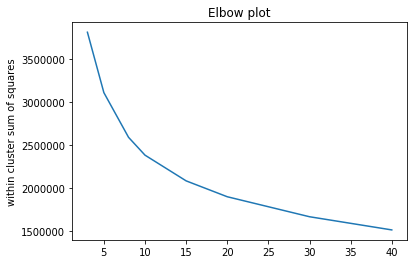

In [55]:
#elbow plot
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

## Optimal clusters

In [117]:
#optimal number of clusters is around 40
cl = KMeans(10)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
#outlier removal


def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [ ]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

In [ ]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [ ]:
#empirical best threshold 1 stdev
newresults, labels = remove_outliers(results, cl,1)

In [ ]:
%run silhouette_plotter.py
X=results
range_n_clusters = [20]
if len(newresults) <20000:
    silhouette_plotter(X, range_n_clusters)

In [123]:
#subset results for tsne
max_size = len(results)
subset_results = []
lbls = []
for c in np.unique(cl.labels_):
    mask = (cl.labels_==c)
    c_size = np.sum(mask)
    if c_size < max_size:
        lbls.extend(list(cl.labels_[cl.labels_==c]))
        subset_results.append(results[mask])
lbls=np.array(lbls)
subset_results=np.vstack(subset_results)

In [125]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(subset_results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 239630 samples in 0.344s...
[t-SNE] Computed neighbors for 239630 samples in 209.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 239630
[t-SNE] Computed conditional probabilities for sample 2000 / 239630
[t-SNE] Computed conditional probabilities for sample 3000 / 239630
[t-SNE] Computed conditional probabilities for sample 4000 / 239630
[t-SNE] Computed conditional probabilities for sample 5000 / 239630
[t-SNE] Computed conditional probabilities for sample 6000 / 239630
[t-SNE] Computed conditional probabilities for sample 7000 / 239630
[t-SNE] Computed conditional probabilities for sample 8000 / 239630
[t-SNE] Computed conditional probabilities for sample 9000 / 239630
[t-SNE] Computed conditional probabilities for sample 10000 / 239630
[t-SNE] Computed conditional probabilities for sample 11000 / 239630
[t-SNE] Computed conditional probabilities for sample 12000 / 239630
[t-SNE] Computed conditional prob

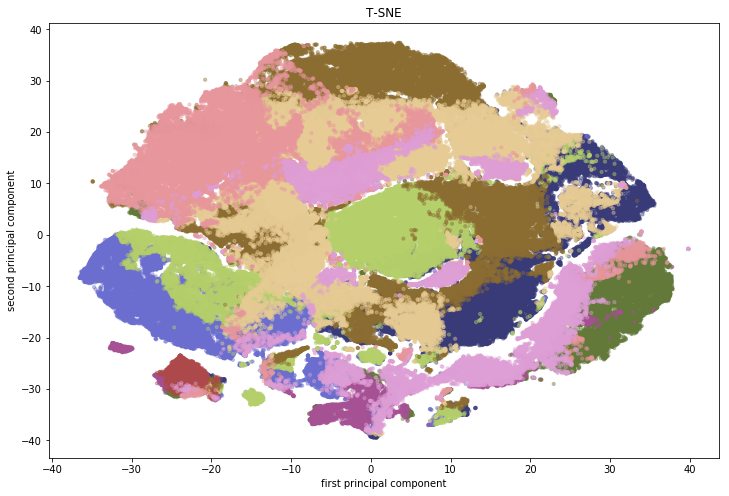

In [126]:
plt.figure(figsize=(12,8))

plt.scatter(tsne_results[:,0], tsne_results[:,1], s=10,c=lbls,cmap='tab20b', alpha=.4)


# leg = plt.legend()




# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

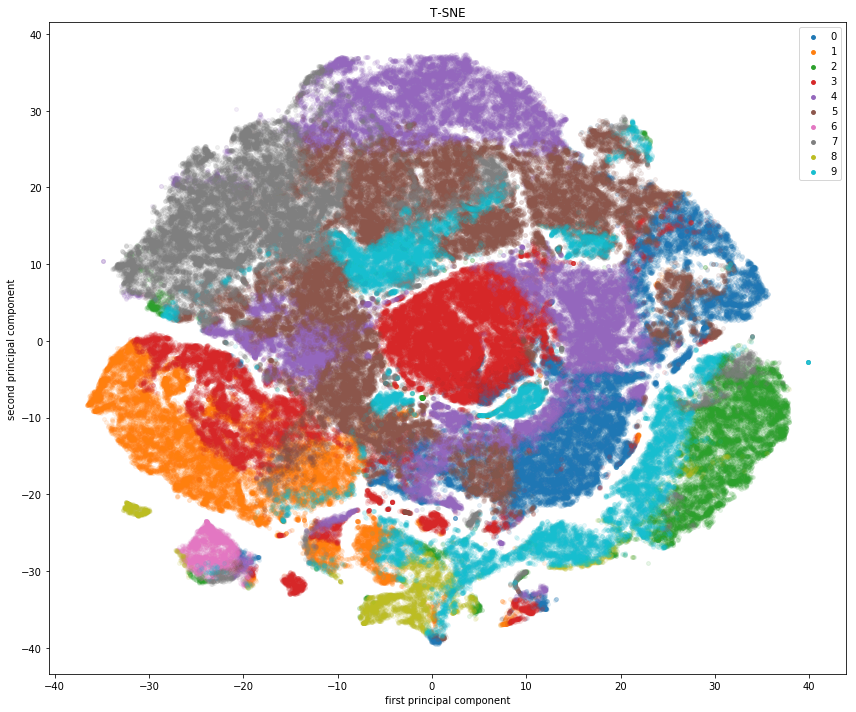

In [130]:
plt.figure(figsize=(12,10))
for c in np.unique(lbls):
    mask = lbls==c
    if np.sum(mask) <0:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=15,alpha=.1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.tight_layout()

In [ ]:

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for c in np.unique(cl.labels_):
#     mask = cl.labels_==c
#     if np.sum(mask) <50:
#         lbl = '_nolegend_'
#     else:
#         lbl = c
#     ax.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], tsne_results[mask][:,2], s=10, alpha=.01,label=lbl)
# leg = plt.legend()
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
# ax.set_xlabel('first principal component')
# ax.set_ylabel('second principal component')
# ax.set_zlabel('third principal component')
# ax.view_init(elev=30, azim=0)
# plt.show()


In [ ]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
# plt.xlim(0,10)
# plt.ylim(-10,10)

In [ ]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

In [ ]:
# #recluster after changes
# cl = KMeans(20).fit(results)
newcl = KMeans(40).fit(newresults)

In [ ]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

In [ ]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

In [ ]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)
# ax.set_xlim3d(-1,1)
# ax.set_ylim3d(-3,3)
# ax.view_init(elev=-0, azim=90)
# for ii in range(10,360,10):
#     ax.view_init(elev=10, azim=ii)
#     fig.savefig("movie/movie{}.png".format(ii))

## Label centroids with cluster

In [58]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = log.inverse_transform(scale.inverse_transform(pca.inverse_transform(c)))
df_summary = pd.DataFrame(centroids, columns = data.columns)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [59]:
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [60]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
9,8.947619,10.285792,17.489610,2.401799,1.082957e+04,1247.275154,27.561662,3.357229,1.603625e+04,1602.981072,...,1395.735439,0.001597,0.003615,2.670358e+33,1.935784e+46,3.863432e+74,1.775554e+84,8.584290,5.717875,47143
0,5.642061,7.704934,5.393315,1.197373,2.059565e+03,378.627043,10.970668,1.877195,4.286868e+03,564.401679,...,299.716998,0.005641,0.014800,9.659186e+40,1.832801e+57,1.343590e+110,4.948037e+121,8.768203,3.973137,39367
7,7.148378,56.839758,4.579880,0.688407,1.795065e+03,259.152698,10.205222,0.096896,3.709093e+03,67.549886,...,295.554118,0.002307,0.004501,5.848331e+26,5.943234e+30,1.048836e+94,6.758906e+99,5.242501,3.557698,35282
6,5.897954,7.715505,2.326298,0.463478,6.882824e+02,128.351364,5.755500,0.961049,2.415778e+03,321.791665,...,236.260701,0.004410,0.011179,1.108636e+33,8.867066e+43,2.945725e+60,4.337167e+63,5.371072,2.780474,28428
4,7.653474,9.153080,77.793579,10.852640,3.707963e+04,4865.623621,145.368695,16.845129,4.523164e+04,5068.821698,...,2816.221960,0.006084,0.015430,5.124201e+38,3.739951e+55,2.285734e+100,1.913064e+115,12.435821,24.957759,26898
2,19.096119,199.244035,37.036451,2.453783,1.889978e+04,1004.996054,57.050319,0.441225,2.555825e+04,125.749888,...,1899.071361,0.004296,0.008418,5.773206e+21,4.286024e+26,1.006117e+78,1.945209e+87,8.086085,8.927059,22325
3,26.738705,29.943611,208.338459,9.739923,1.049395e+05,4078.359308,244.367322,9.589058,1.258482e+05,4343.822600,...,10957.505402,0.001885,0.004607,2.876086e+28,2.877949e+41,9.001773e+63,8.215822e+78,12.965422,11.246821,21441
8,13.473809,15.521618,2158.128696,117.857112,6.676656e+05,51438.246793,3029.070299,129.296628,7.172324e+05,48282.216650,...,56187.838323,0.009057,0.029730,1.311949e+32,4.342115e+46,8.709252e+79,2.367729e+96,13.098755,117.200278,12076
1,438.097296,369.166462,4507.789766,15.613091,1.549941e+06,3472.885232,4010.546155,14.794942,1.553029e+06,3999.540138,...,158494.607579,0.011405,0.060731,2.931536e+18,3.926052e+29,5.956028e+39,5.054828e+47,17.099079,33.595889,4325
5,28.060735,20.623705,55.458908,3.514831,1.311533e+04,551.316409,68.590061,4.658564,1.863531e+04,957.992610,...,1419.692197,4.962534,141.876880,6.543322e+32,1.901452e+47,6.554516e+69,1.462968e+86,12.909247,7.950272,2345


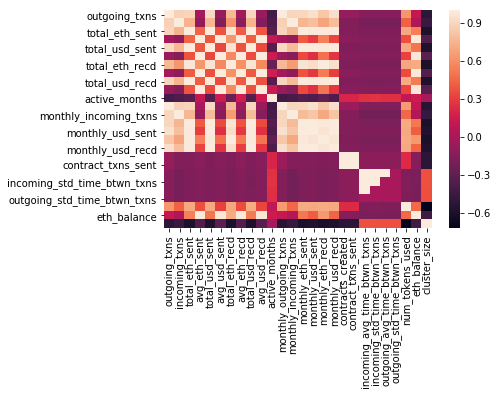

In [61]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [62]:
arr = df_summary.values

In [63]:
arr.shape

(10, 26)

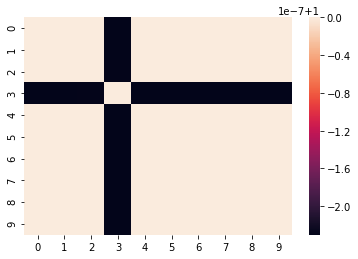

In [64]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

In [65]:
# for col in df_summary.columns:
#     df_summary[col].hist()
#     plt.title(col)
#     plt.show()

In [66]:
p = PCA(n_components=3)

In [67]:
vectors = p.fit_transform(arr[:8,:])

In [68]:

xs = vectors[:,0]
ys = vectors[:,1]
zs = vectors[:,2]

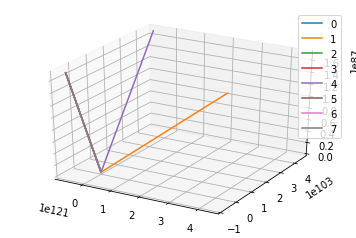

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
    ax.plot([0,x], [0,y],[0,z], label=i)
plt.legend()

## Review Etherscan Labels

In [ ]:
sql = '''
SELECT es.label,es.category, a.*  FROM `eth-tokens.test.clean_avg_1MM_with_balances_tokens` a
INNER JOIN `eth-tokens.alldata.etherscan_labelcloud` es
ON a.address = es.address
WHERE es.label IS NOT NULL

'''

dflabel = client.query(sql).to_dataframe()

In [25]:
dflabel.shape

(182, 28)

In [70]:
lbls = []
for i, row in dflabel.iterrows():
    lbls.append(list(df['address'].values).index(row['address']))

In [71]:
dflabel['cluster'] = [cl.labels_[i] for i in lbls]

In [72]:
dflabel

,label,category,address,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster
0,Bgogo_1,Exchange,0x7a10ec7d68a048bdae36a70e93532d31423170fa,4634,42,55512.9469664,11.979487908,1.193449e+07,2.575420e+03,58124.066213484,...,4.162975e+06,0,0,1.383690e+05,1.409740e+05,1.257425e+03,4.127817e+03,5,486.335359084,1
1,Bgogo_2,Exchange,0xce1bf8e51f8b39e51c6184e059786d1c0eaf360f,36,5043,57900,1608.333333333,1.248853e+07,3.469036e+05,61671.7841197,...,4.418291e+06,0,0,9.234072e+02,1.880744e+04,1.373183e+05,1.435795e+05,16,4361.036312862,1
2,Fake_Phishing2168,Phish/Hack,0xe55996c55e188fbcf95ed6ca96fa933171c05fa0,39,3,4.49814198,0.115336974,9.625667e+02,2.468120e+01,6.29532325,...,6.588822e+02,0,0,8.628800e+04,4.121018e+03,1.129844e+05,2.444354e+05,1,1.77895327,6
3,Fake_Phishing2172,Phish/Hack,0x0cd4ea9b68ced287fc25923b071c0b1a0a14e9c6,3,6,3,1,1.254080e+03,4.180267e+02,12.04453369,...,1.262294e+03,0,0,4.478660e+04,3.980184e+04,1.939075e+05,2.740272e+05,1,9.04220269,6
4,Fake_Phishing1822,Phish/Hack,0xce9e24dffdb3dc08efe33ad3db858576c3f27d5d,5,15,0.152271677,0.030454335,7.338025e+01,1.467605e+01,13.149842315,...,1.256999e+03,0,0,1.748954e+05,2.330848e+05,5.331485e+05,3.699470e+05,2,12.990745638,6
5,Fake_Phishing1816,Phish/Hack,0xebfce0f5135c0bd67f9fa5b1ae1366a566f659ff,5,15,0.10558692,0.021117384,4.933489e+01,9.866978e+00,10.58902434,...,9.773935e+02,0,0,1.039599e+05,1.948596e+05,2.899012e+05,4.372348e+05,2,10.47367242,6
6,Rate3_Wallet2,ICO Wallets,0x841991ffe0dafd619bc517d82ee4700c37136140,7,5,5040,720,1.877741e+06,2.682487e+05,9684.7308,...,8.097912e+05,0,0,1.017963e+06,1.390813e+06,7.171660e+05,1.001970e+06,3,4644.727651874,8
7,Fake_Phishing1978,Phish/Hack,0x0fa3202e9f247f9349352c4296d2bbd6c7fa11b4,190,91,0.6293,0.003312105,2.256344e+02,1.187549e+00,2.543249492,...,1.815959e+02,0,0,4.102533e+04,2.040587e+05,4.965298e+04,4.389640e+05,35,1.73592354,7
8,Bitmax_1,Exchange,0x03bdf69b1322d623836afbd27679a1c0afa067e9,1061,1081,3348.282084541,3.155779533,7.798949e+05,7.350565e+02,6077.344511858,...,2.748006e+05,0,0,9.625878e+03,6.593208e+04,9.759738e+03,5.313994e+04,13,3871.119196898,1
9,TheOcean,0x Ecosystem,0x7219612be7036d1bfa933e16ca1246008f38c5fe,5,7,0.005,0.001,2.393750e+00,4.787500e-01,59.16455627,...,5.702990e+03,0,0,2.607233e+04,4.326595e+04,6.284165e+05,1.136622e+06,14,13.088429247,6


In [73]:
for clust in range(cl.n_clusters):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label','category']])
    print('\n\n\n')

cluster 0
labelled points: 0
total points: 39367
Empty DataFrame
Columns: [label, category]
Index: []




cluster 1
labelled points: 81
total points: 4325
                 label      category
0              Bgogo_1      Exchange
1              Bgogo_2      Exchange
8             Bitmax_1      Exchange
13            BigONE_1      Exchange
18   Fake_Phishing1624    Phish/Hack
23               FCoin      Exchange
25           Gate.io_3      Exchange
26            Huobi_16      Exchange
30            Huobi_15      Exchange
39           Gate.io_2      Exchange
40                 Uex      Exchange
41          Bitfinex_5      Exchange
42           Gate.io_1      Exchange
43              Bilaxy      Exchange
46          BitUN.io_2      Exchange
47                Cobo    Wallet App
55              Okex_1      Exchange
59      WhalesburgPool        Mining
62       2Miners_PPLNS        Mining
63           Binance_4       Binance
64           Binance_4      Exchange
65            HitBTC_2      Exc

centralization of ownership

In [ ]:
total_eth = {}
total_addresses = {}

for clust in range(cl.n_clusters):
    mask = cl.labels_==clust
    eth = np.sum(df[mask]['eth_balance'])
    size = np.sum(cl.labels_==clust)
    total_eth[clust] = eth
    total_addresses[clust] = size

In [ ]:
plt.pie(total_eth.values(), labels=total_eth.keys())
plt.title('Centralization of Ownership by Cluster')
plt.show()

In [ ]:
plt.pie(total_addresses.values(), labels=total_addresses.keys())
plt.title('Addresses per cluster')
plt.show()

In [ ]:

names = np.array(list(total_eth.keys()))
values = np.array(list(total_eth.values()))
indices = np.argsort(values)

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_eth)),values/sum(values)*100,tick_label=names)
plt.title('Total Value by Cluster')
plt.xlabel('cluster number')
plt.ylabel('% of total value')
# plt.yscale('log')
plt.tight_layout()
plt.show()




In [ ]:

names = np.array(list(total_addresses.keys()))
values = np.array(list(total_addresses.values()))

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_addresses)),values/sum(values)*100,tick_label=names)
plt.title('Addresses per Cluster')
plt.yscale('log')
plt.xlabel('cluster number')
plt.ylabel('% of total addressses')
plt.show()

In [ ]:


for clust in range(cl.n_clusters):
    cluster_data = df[cl.labels_==clust]
    print('cluster {}'.format(clust))
    logbins = np.logspace(0,8,16)
    plt.hist(cluster_data['incoming_avg_time_btwn_txns'], bins=logbins)
    plt.xscale('log')
    plt.show()
    

In [74]:
labelresults = pipe.fit_transform(dflabel.iloc[:,3:-1])

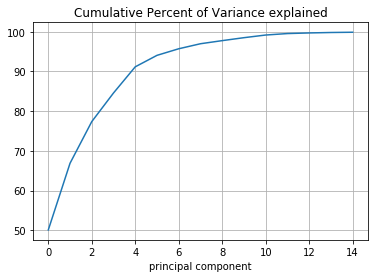

In [75]:
pca = pipe.named_steps['PCA']
plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

Text(0.5,1,'Calinski Harabaz Scores')

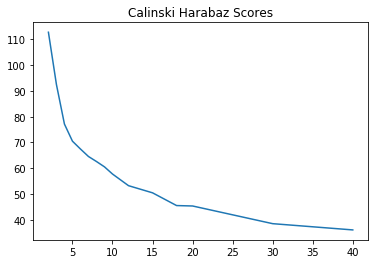

In [76]:
#scoring metric?
clusters = [2,3,4,5,6,7,8,9,10,12,15,18,20,30,40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(labelresults)
    score = ch_score(labelresults, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

In [77]:
cl = KMeans(15).fit(labelresults)
dflabel['cluster'] = [cl.labels_[i] for i in range(len(dflabel))]

In [103]:
time_start = time.time()
tsne_label = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=20000)
tsne_results_label = tsne_label.fit_transform(labelresults)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 182 samples in 0.000s...
[t-SNE] Computed neighbors for 182 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 182 / 182
[t-SNE] Mean sigma: 1.921014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.506050
[t-SNE] KL divergence after 900 iterations: 0.353187
t-SNE done! Time elapsed: 0.5904905796051025 seconds


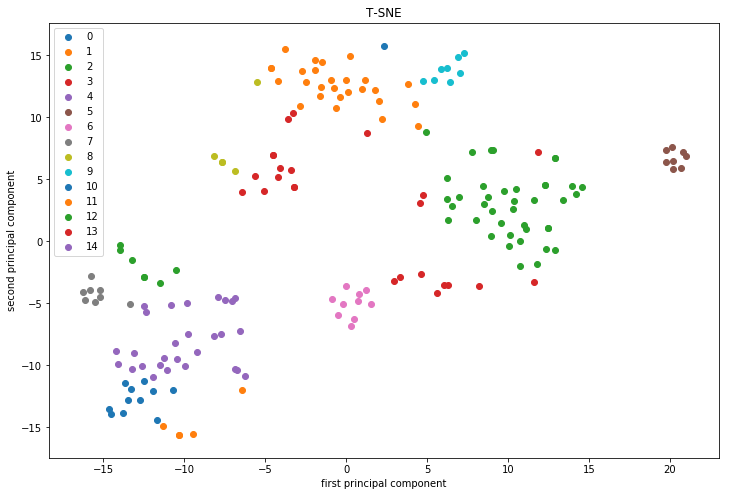

In [106]:
plt.figure(figsize=(12,8))
for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

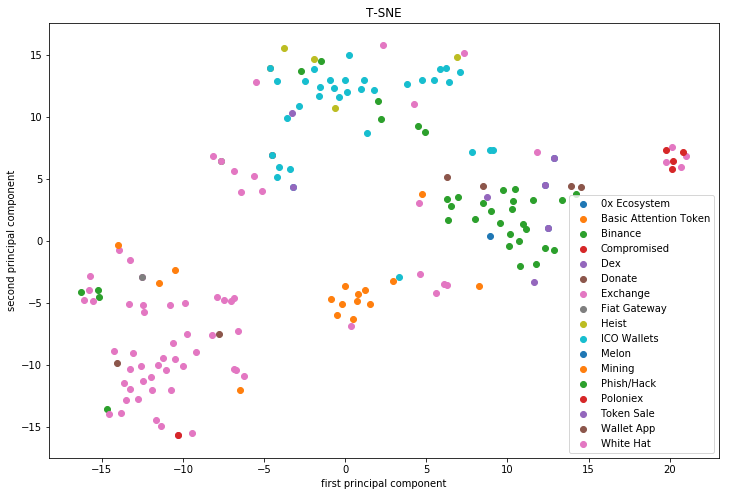

In [107]:
plt.figure(figsize=(12,8))

for c in np.unique(dflabel['category']):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

## subset original T-SNE results
create a mask for all points that are labelled

In [154]:
labeled_addresses = dflabel['address'].values

labelmask = np.array([addr in labeled_addresses for addr in df['address'] ] )

In [218]:
#helper function for category mask
def cat(addr, labeled_addresses, dflabel):
    if addr not in labeled_addresses:
        return False
    else:
        idx = int(np.where(labeled_addresses==addr)[0][0])
        return dflabel['category'][idx]

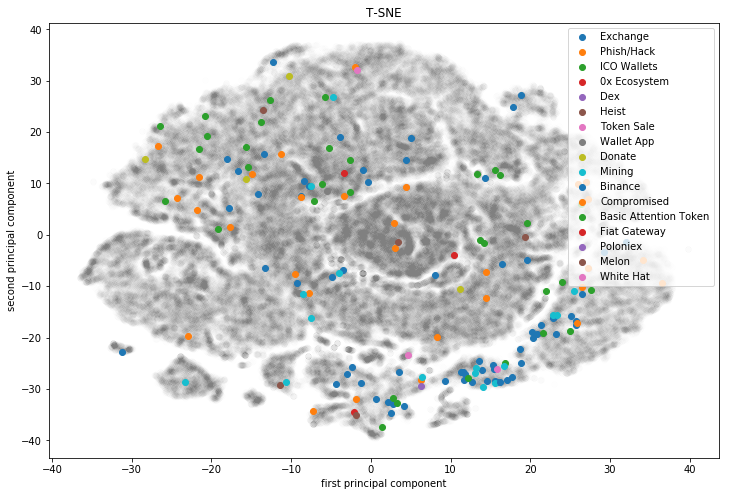

In [226]:
subset, not_subset  = tsne_results[labelmask] , tsne_results[~labelmask]
plt.figure(figsize=(12,8))
#not labelled points
plt.scatter(not_subset[:,0], not_subset[:,1], c='gray', alpha=.005)

#categories
cats = np.array([cat(addr, labeled_addresses, dflabel) for addr in df['address'] ])

#labelled points
for c in list(dflabel['category'].unique()):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    
    #category mask
    catmask = cats == c
    
    plt.scatter(tsne_results[(labelmask & catmask)][:,0], tsne_results[(labelmask & catmask)][:,1], alpha=1,label=lbl)

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

In [ ]:
for clust in range(cl.n_clusters):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label', 'category']])
    print('\n\n\n')